# 人脸检测--传统方法

随着深度学习相关技术的进步，基于深度学习的人脸检测方法逐渐成为主流。

然而，依然有必要对传统的人脸检测方法进行学习和理解

## 基本思路

从一张图像中找到人脸目标，需要找寻人脸的特点。

### 方法1:模板匹配

一种浅显且直白的方式，就是利用模板匹配算法来实现，如下图所示

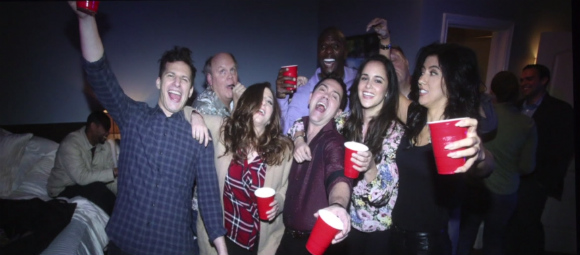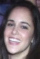

显然，这种方法不够好。无法通用的检索出“人脸”这个概念。

由于人脸缺少一些模式化的特征，不具备特殊的纹理、形状等规律，因此很难利用初等图像处理的方法来得到普世的结果。

**肤色检测** 而通过肤色划分出人脸区域，通常是较为常见的一种做法。

除此之外，将图像分成小块，并对每个小块进行特征提取，通过机器学习的方式，也可以实现人脸检测。

需要注意的是，传统方法由于缺少特征的鲁棒性，无法获取高维特征表述，因此鲁棒性不够

可以考虑不同方法的叠加进行实现。

### 方法二：肤色检测

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

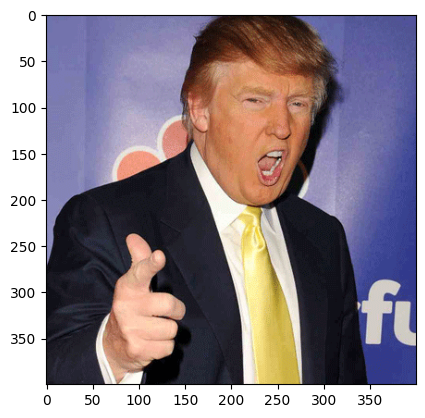

In [16]:
img1 = cv2.imread("../../dataset/d1.png")
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(img2)

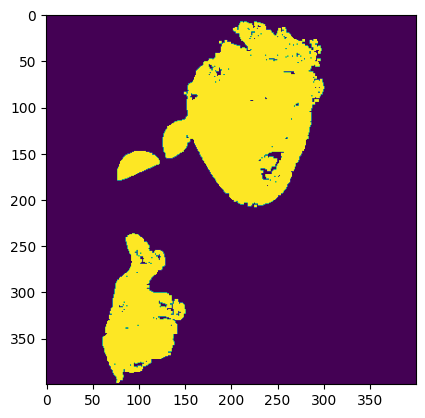

In [17]:
img_HSV = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
HSV_mask = cv2.inRange(img_HSV, (0, 60, 60), (20,255,255)) 
HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
plt.imshow(HSV_mask)

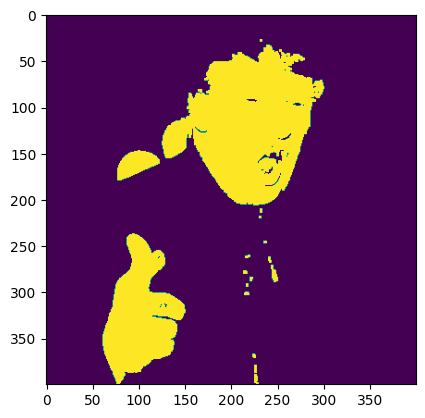

In [18]:
img_YCrCb = cv2.cvtColor(img1, cv2.COLOR_BGR2YCrCb)
YCrCb_mask = cv2.inRange(img_YCrCb, (80, 135, 85), (255,255,255))
YCrCb_mask[np.abs(img_YCrCb[:, :, 1] - img_YCrCb[:, :, 2])<15] = 0 
YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
plt.imshow(YCrCb_mask)

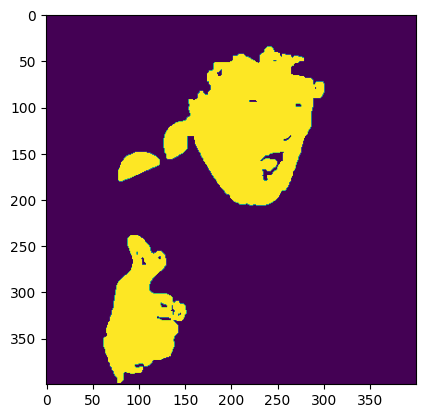

In [19]:
final_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
final_mask=cv2.medianBlur(final_mask,3)
final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, np.ones((4,4), np.uint8))
plt.imshow(final_mask)

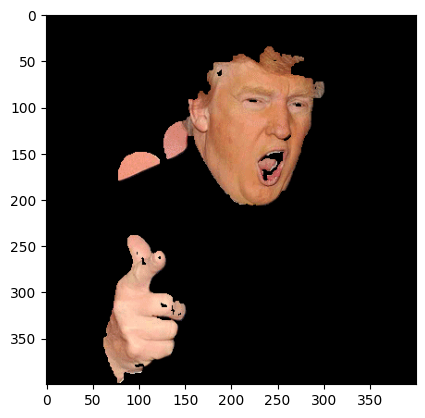

In [20]:
img2[final_mask == 0] = 0
plt.imshow(img2)

同hsv一样，ycrcb格式也是一种颜色空间。

其中，Y表示亮度，Cr和Cb表示色度信息。

常用于肤色检测。(因为肤色载这一空间更加集中)

通常，肤色检测中，采用的阈值为

Y>80, Cr>135, Cb>85, 且|Cr-Cb|>15

而HSV的肤色检测阈值为

$H \in\{0, 20\}\{150, 180\}$

$V \in \{60, 255\}$

$S \in \{60, 255\}$

需要注意的是，颜色分割只能作为识别的辅助进行。因为其非常容易收到光照和肤色的影响。

### 方法3：手工特征+分类器

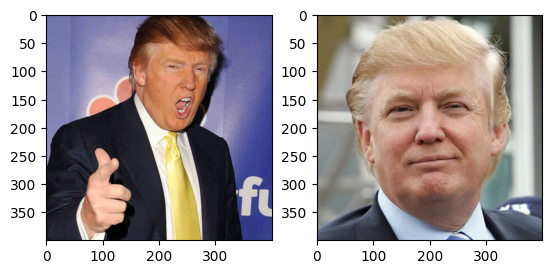

In [97]:
img_a = cv2.imread("../../dataset/d1.png")
img_b = cv2.imread("../../dataset/d2.jpg")

sift = cv2.SIFT_create()

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB))

人脸的另一个规律在于，五官之间存在一定的模式

这种模式很难拿自然语言完整的描述出来，大致上，人脸图像应当符合这样的内容

如 ：

    - 眼睛区域暗于脸颊区域
    
    - 嘴部区域暗于周围区域等
    
    

那么本质上，我们只需要**总结出脸部区域的明暗变化**，那么在待检测区域中发现了类似的模式，则可以认为是一个人脸。

那么如何总结出人脸模式呢？

机器学习

这里涉及两个部分：

1. 特征提取

2. 分类器训练

#### 特征提取：HOG特征

hog, higtogram of oriented gradient, 是抓取图像轮廓的算法。

具体上，将一张图像切成很多个区域，并从每个区域中提取出方向梯度，作为特征。

其基本步骤包括：

1. 图像预处理: 灰度化、归一化、平滑等
2. 计算梯度: 用sobel计算梯度的赋值和方向
3. 分割图像：将图像切割成大小相同的cell。并构建直方图
4. 块归一化：将每个patch中的图直方图进行归一化，消除光影影响
5. 将所有直方图组合成一个特征向量

In [98]:
# 块大小
patch_size = 8
# 直方图数量
nbins = 9


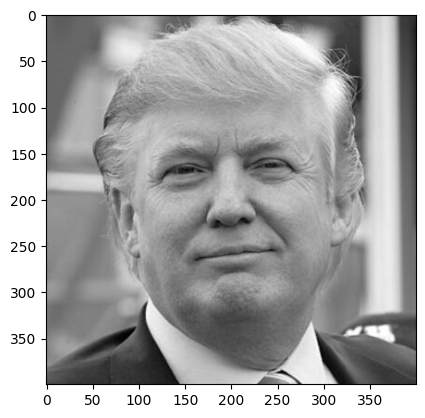

In [101]:
img = cv2.imread('../../dataset/d2.jpg', 0)
plt.imshow(img, cmap='gray')

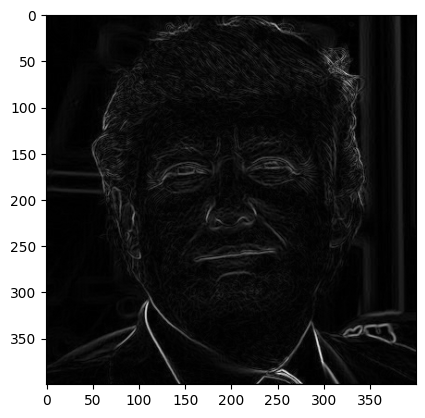

In [123]:
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
mag, ang = cv2.cartToPolar(gx, gy)
plt.imshow(mag, cmap='gray')

In [137]:
ph = patch_size
pw = patch_size
h, w = img.shape

n_h = h // ph
n_w = w // pw

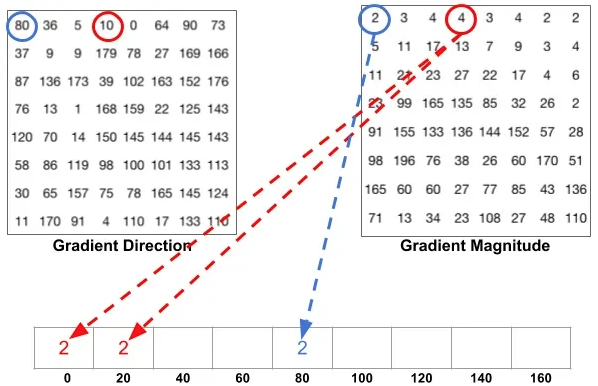

In [138]:
bin_width = 360 // nbins
bins = np.zeros((mag.shape[0], mag.shape[1], nbins))
for i in range(nbins):
        angle_bin = ang < (i + 1) * bin_width
        angle_bin = angle_bin.astype(np.float32)
        bins[:, :, i] = mag * angle_bin

In [148]:
feature_vectors = np.zeros([img.shape[0] // patch_size, img.shape[1] // patch_size, nbins])
for iidx, i in enumerate(range(0, img.shape[0] - patch_size + 1, patch_size)):
        for jidx, j in enumerate(range(0, img.shape[1] - patch_size + 1, patch_size)):
            cell_bins = bins[i:i+patch_size, j:j+patch_size, :]
            cell_hist = np.sum(cell_bins, axis=(0, 1))
            feature_vectors[iidx, jidx, :] = cell_hist

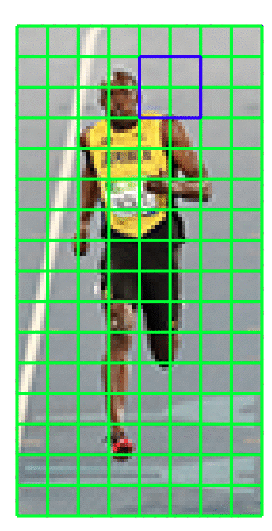

归一化，就是将临近四个patch放到一起进行归一化

归一化的目的在于去除阴影和光照的影响，尽可能地令光照统一。

归一化的方法包括采用l2,l1等，如以下公式所示

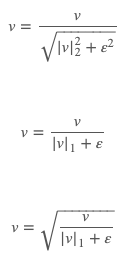


In [150]:
block_size = 2

block_size_cells = (block_size, block_size)
feature_vectors = np.array(feature_vectors)
eps = 1e-7
for i in range(0, feature_vectors.shape[0] - block_size + 1, block_size):
        for j in range(0, feature_vectors.shape[1] - block_size + 1, block_size):
            block = feature_vectors[i:i+block_size, j:j+block_size, :]
            block_sum = np.sum(block)
            block_norm = block / (block_sum + eps)
            feature_vectors[i:i+block_size, j:j+block_size, :] = block_norm

In [152]:
features = feature_vectors.reshape(-1)
print(features.shape)

(22500,)


以上，就是hog特征的底层提取方法。

opencv也为提取hog特征提供了接口，具体实现如下所示



In [160]:
hog = cv2.HOGDescriptor()
features = hog.compute(img)
print(features.shape)

(5688900,)


需要注意的是，实际上我们采用滑动窗口的方式来检测人脸。

固定窗口尺寸为50\*50，然后为每个patch提取特征

然后，对提取的特征进行分类器分类。

#### 分类器

支持向量机，在特征空间上找到一个超平面将不同类别分开。

相关内容在机器学习中有所涉及，此处不讲述SVM原理

sklearn库中提供了相关的接口实现

In [161]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 9.8 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 10.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [162]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

训练过程

```
grad = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)

grad.fit(X_train, y_train)

print(grad.best_score_)

print(grad.best_params_)

model = grad.best_estimator_

model.fit(X_train, y_train)

```

测试过程

```
labels = model.predict(patches_hog)
```

### 作业：传统方法的人脸检测

基于传统方法的人脸检测

方法不限，特征不限，分类器不限

要求：使用非深度学习方法完成对人脸的检测

数据集：lfw数据集